# COGS 118B Project

### By Miguel Garcia and Janina Schuhmacher


In [1]:
import sklearn.metrics as metrics
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import time
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.utils import check_X_y
import warnings
warnings.filterwarnings("ignore")

#name the columns
colnames=['age', 'workclass',  'fnlwgt', 'education', 
          'education-num', 'marital-status', 'occupation', 
          'relationship', 'race', 'sex', 'capital-gain', 
          'capital-loss', 'hours-per-week', 'native-country', 'income']

# read data in df
df = pd.read_csv('adult.data', names=colnames, header=None)


In [2]:
# display df header
data_top = df.head()   
data_top

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### Drop null values

In [3]:
df.shape #before dropping nulls

(32561, 15)

In [4]:
for i in colnames:   #ignores all null values
    df = df[(df[i] != ' ?')]

In [5]:
df.shape #after dropping nulls

(30162, 15)

### Keep income only from Americans since it represents most of the data and remove trailing white space

In [6]:
df = df[(df['native-country'] == ' United-States')]
df = df.reset_index()

In [7]:
df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

### Visualize the distribution of each feature

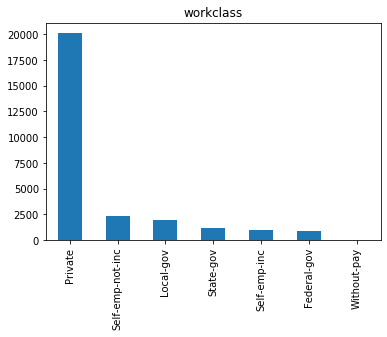

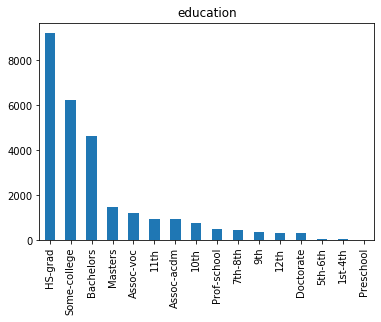

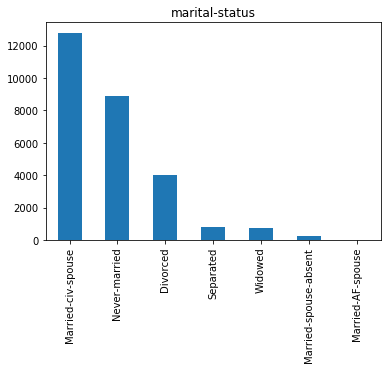

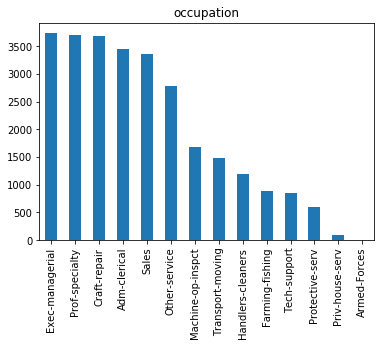

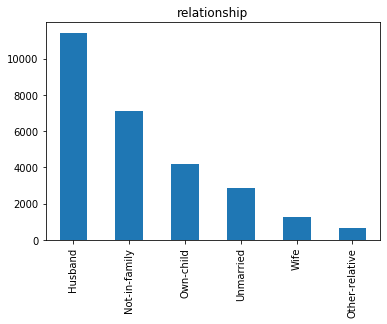

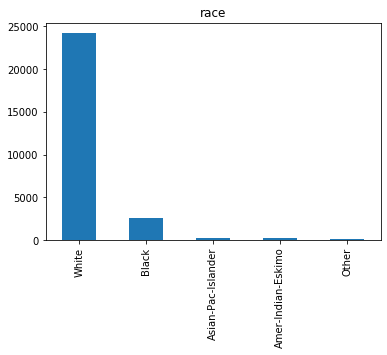

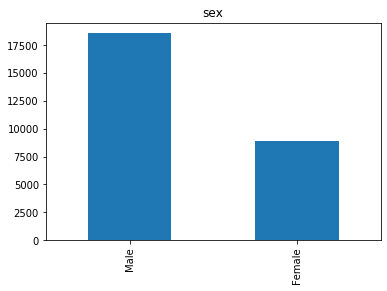

In [8]:
# plotting the frequency of the values

string_columns = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex']

for col in string_columns: 
    fig, ax = plt.subplots()
    df[col].value_counts().plot(ax=ax, kind='bar', title = col)

### One hot encode

In [9]:
new_df = df[['age','fnlwgt','education-num','capital-gain',
             'capital-loss','hours-per-week']]  #non-categorical features (some are not important)
one_hot_cols = ['workclass', 'marital-status',
                'occupation','relationship','race']  #categorical features we care about
for i in one_hot_cols:  #for every categorical feature, onehot encode it
    new_df = new_df.join(pd.get_dummies(df[i],prefix = i))
    
new_df['income'] = pd.DataFrame((df['income'] == '>50K').astype(int))  #if greater than 50k 1 else 0 for label

In [10]:
for i in new_df.columns: #print new columns
    print(i)

age
fnlwgt
education-num
capital-gain
capital-loss
hours-per-week
workclass_Federal-gov
workclass_Local-gov
workclass_Private
workclass_Self-emp-inc
workclass_Self-emp-not-inc
workclass_State-gov
workclass_Without-pay
marital-status_Divorced
marital-status_Married-AF-spouse
marital-status_Married-civ-spouse
marital-status_Married-spouse-absent
marital-status_Never-married
marital-status_Separated
marital-status_Widowed
occupation_Adm-clerical
occupation_Armed-Forces
occupation_Craft-repair
occupation_Exec-managerial
occupation_Farming-fishing
occupation_Handlers-cleaners
occupation_Machine-op-inspct
occupation_Other-service
occupation_Priv-house-serv
occupation_Prof-specialty
occupation_Protective-serv
occupation_Sales
occupation_Tech-support
occupation_Transport-moving
relationship_Husband
relationship_Not-in-family
relationship_Other-relative
relationship_Own-child
relationship_Unmarried
relationship_Wife
race_Amer-Indian-Eskimo
race_Asian-Pac-Islander
race_Black
race_Other
race_Whit

In [11]:
new_df.head(10)

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,...,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,income
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,38,215646,9,0,0,40,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
3,53,234721,7,0,0,40,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,37,284582,14,0,0,40,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
5,52,209642,9,0,0,45,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
6,31,45781,14,14084,0,50,0,0,1,0,...,0,0,0,0,0,0,0,0,1,1
7,42,159449,13,5178,0,40,0,0,1,0,...,0,0,0,0,0,0,0,0,1,1
8,37,280464,10,0,0,80,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
9,23,122272,13,0,0,30,0,0,1,0,...,0,1,0,0,0,0,0,0,1,0


In [12]:
new_df.shape   #shape after all cleaning

(27504, 46)

In [13]:
new_df = new_df.reset_index()

In [14]:
new_df.columns[1:46]

Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week', 'workclass_Federal-gov', 'workclass_Local-gov',
       'workclass_Private', 'workclass_Self-emp-inc',
       'workclass_Self-emp-not-inc', 'workclass_State-gov',
       'workclass_Without-pay', 'marital-status_Divorced',
       'marital-status_Married-AF-spouse', 'marital-status_Married-civ-spouse',
       'marital-status_Married-spouse-absent', 'marital-status_Never-married',
       'marital-status_Separated', 'marital-status_Widowed',
       'occupation_Adm-clerical', 'occupation_Armed-Forces',
       'occupation_Craft-repair', 'occupation_Exec-managerial',
       'occupation_Farming-fishing', 'occupation_Handlers-cleaners',
       'occupation_Machine-op-inspct', 'occupation_Other-service',
       'occupation_Priv-house-serv', 'occupation_Prof-specialty',
       'occupation_Protective-serv', 'occupation_Sales',
       'occupation_Tech-support', 'occupation_Transport-moving',
       'rela

### Get indexes for each individual feature and their respective names

In [15]:
ranges = [[1,2],[3,4],[4,5],[5,6],[6,7],[7,14],[14,21],[21,35],[35,41],[41,46],[1,46]]
columns = ['Age', 'Education','Capital Gain','Capital Loss','Hours Per Week',
           'Workclass','Marital Status','Occupation','Relationship','Race' ,'All Columns']

### Permutate/Shuffle the dataframe before applying algorithms

In [16]:
new_df = new_df.reindex(np.random.permutation(new_df.index))
new_df.head(10)

,index,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Private,...,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,income
17084,17084,26,485117,13,0,0,20,0,0,1,...,0,1,0,0,0,0,0,0,1,0
16802,16802,25,148888,9,0,0,60,0,0,0,...,0,0,0,0,0,0,0,0,1,1
12805,12805,38,153066,14,0,0,45,0,0,1,...,0,0,0,0,0,0,0,0,1,1
11877,11877,22,141297,10,0,0,40,0,0,1,...,0,1,0,0,0,0,0,0,1,0
6147,6147,40,42703,11,0,0,40,0,0,1,...,0,0,1,0,0,0,0,0,1,0
10560,10560,60,191446,9,99999,0,40,0,0,1,...,0,0,0,0,0,0,0,0,1,1
6637,6637,49,94754,14,0,0,40,1,0,0,...,0,0,0,0,0,0,0,0,1,1
6533,6533,32,151053,9,0,0,40,0,0,1,...,0,0,0,0,0,0,0,0,1,1
3577,3577,30,73796,13,0,0,40,0,1,0,...,0,0,0,0,0,0,0,0,1,0
15547,15547,35,401930,9,0,1887,42,0,0,1,...,0,0,0,1,0,0,0,0,1,1


### Function to return results for each classifier

In [17]:
def return_results(clf,string,is_svm,is_dummy,i):
    print('---------- Results Summary for',string,'for the column:',columns[i],'----------')
    print()
    X = sc.fit_transform(new_df.iloc[:,ranges[i][0]:ranges[i][1]])  #apply standard scaler
    
    X_train = X[:num_training]   #training features 80% of data
    X_test = X[num_training:]    #testing features 20% of data
    Y_train = Y[:num_training]   #training labels 80% of data
    Y_test = Y[num_training:]   #testing labels 20% of data
    start_time = time.time()  #start counting time
    clf.fit(X_train, Y_train) #train algorithm
    scores = 0
    if is_svm == True:  #if it is an svm we do cross validation
        scores = cross_val_score(clf, X_test, Y_test, cv=5)  #5 cross validation folds for accuracy
        scores = max(scores)
    elif is_dummy == True:   #if it is dummy we calculate accuracy differently
        X_trainc, Y_trainc = \
                         check_X_y(X=X_train, y=Y_train)
        clf.fit(X=X_trainc, y=Y_trainc)
        scores = clf.score(X_test,Y_test)
                
    else:
        scores = clf.score(X_test,Y_test) #otherwise use default function
        
    print(str(time.time() - start_time)+" seconds for ", string, " to train") #end time counting and print
    print('Using' ,columns[i],'as a predictor for ' ,string,
          ' we get train accuracy of: ',clf.score(X_train,Y_train))  # train accuracy
    print('Using' ,columns[i],'as a predictor for ' ,string,
          ' we get test accuracy of: ',scores)  # calculate accuracy using 20%
    print()
    
    #confusion matrix
    cf_matrix = pd.DataFrame(confusion_matrix(Y_test, clf.predict(X_test)),index = ["True <50k", "True >50k"],
                columns = ["Pred <50k", "Pred >50k"])
    print('Confusion Matrix: ')
    print(cf_matrix)
    print()
    
    #f1 score
    score_f1 = f1_score(Y_test, clf.predict(X_test))
    print('F1-score is:',score_f1)

    #plot ROC
    fpr, tpr, thr = metrics.roc_curve(Y_test, clf.predict(X_test))
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic Curve for ' + str(string))
    plt.plot(fpr, tpr)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    print()

### Classifiers we will use with different initializations

In [18]:
#classifiers we will use with different initializations
classifiers = [GaussianNB()]
classifiers.append(SVC(kernel = 'linear',gamma ='auto',random_state = 50))
classifiers.append(SVC(kernel = 'sigmoid',gamma ='auto',random_state = 50))
classifiers.append(SVC(kernel = 'rbf',gamma ='auto',random_state = 50)) #radial basis function kernel
classifiers.append(MLPClassifier(solver='lbfgs', alpha=10,hidden_layer_sizes=(5, 2)))
classifiers.append(MLPClassifier(activation = 'logistic',solver='lbfgs', alpha=10,hidden_layer_sizes=(5, 2)))
classifiers.append(MLPClassifier(activation = 'tanh',solver='lbfgs', alpha=10,hidden_layer_sizes=(5, 2)))
classifiers.append(DummyClassifier(strategy="most_frequent")) #“most_frequent”: always predicts the most frequent label in the training set.
classifiers.append(DummyClassifier(strategy="stratified")) #“stratified”: generates predictions by respecting the training set’s class distribution.
classifiers.append(DummyClassifier(strategy="prior"))#“prior”: always predicts the class that maximizes the class prior (like “most_frequent”) and predict_proba returns the class prior.

### Name of the Classifiers

In [19]:
names = ['GaussianNB','SVM with Linear Kernel','SVM with Sigmoid Kernel','SVM with Radial Basis Function Kernel',
        'Neural Network with ReLU activation','Neural Network with Logistic Sigmoid activation',
        'Neural Network with tanh activation', 'Dummy Classifier that predicts most frequent',
        'Dummy Classifier that makes stratified predictions',
        'Dummy Classifier that maximizes the prior']

### Calculate accuracy per each feature

--------------- Returning Algorithm Results Summary for the feature: Age ---------------

---------- Results Summary for GaussianNB for the column: Age ----------

0.0023212432861328125 seconds for  GaussianNB  to train
Using Age as a predictor for  GaussianNB  we get train accuracy of:  0.7425805571967459
Using Age as a predictor for  GaussianNB  we get test accuracy of:  0.7580439920014543

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4170          0
True >50k       1331          0

F1-score is: 0.0


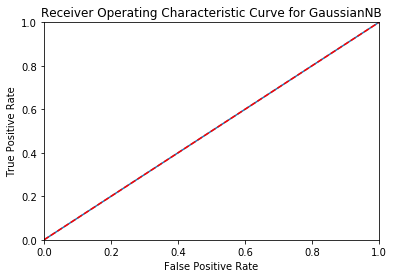


---------- Results Summary for SVM with Linear Kernel for the column: Age ----------

3.8176722526550293 seconds for  SVM with Linear Kernel  to train
Using Age as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.7425805571967459
Using Age as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7581818181818182

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4170          0
True >50k       1331          0

F1-score is: 0.0


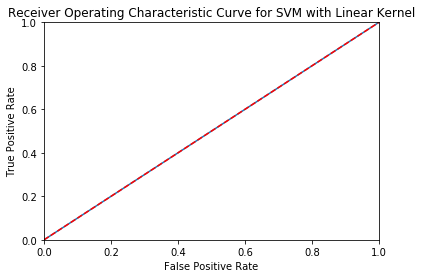


---------- Results Summary for SVM with Sigmoid Kernel for the column: Age ----------

7.63996696472168 seconds for  SVM with Sigmoid Kernel  to train
Using Age as a predictor for  SVM with Sigmoid Kernel  we get train accuracy of:  0.6370494932509203
Using Age as a predictor for  SVM with Sigmoid Kernel  we get test accuracy of:  0.6881818181818182

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3239        931
True >50k        987        344

F1-score is: 0.2640061396776669


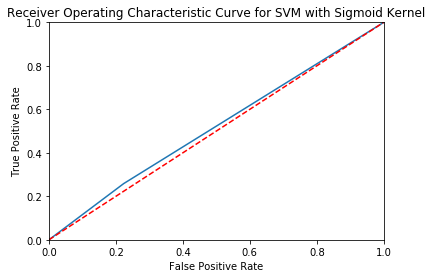


---------- Results Summary for SVM with Radial Basis Function Kernel for the column: Age ----------

5.587929010391235 seconds for  SVM with Radial Basis Function Kernel  to train
Using Age as a predictor for  SVM with Radial Basis Function Kernel  we get train accuracy of:  0.7425805571967459
Using Age as a predictor for  SVM with Radial Basis Function Kernel  we get test accuracy of:  0.7581818181818182

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4170          0
True >50k       1331          0

F1-score is: 0.0


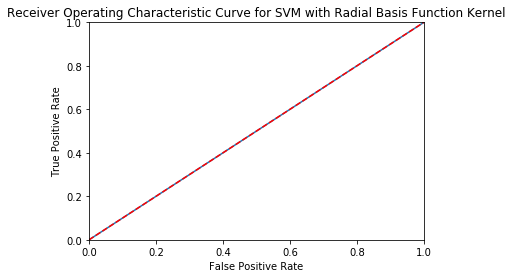


---------- Results Summary for Neural Network with ReLU activation for the column: Age ----------

0.14626193046569824 seconds for  Neural Network with ReLU activation  to train
Using Age as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.7425805571967459
Using Age as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7580439920014543

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4170          0
True >50k       1331          0

F1-score is: 0.0


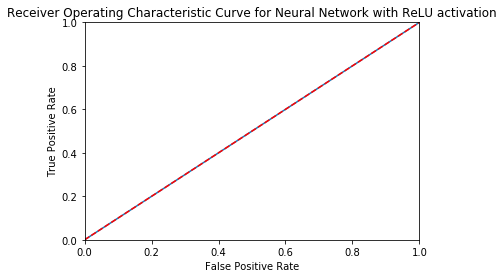


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Age ----------

0.36481809616088867 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Age as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.7425805571967459
Using Age as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7580439920014543

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4170          0
True >50k       1331          0

F1-score is: 0.0


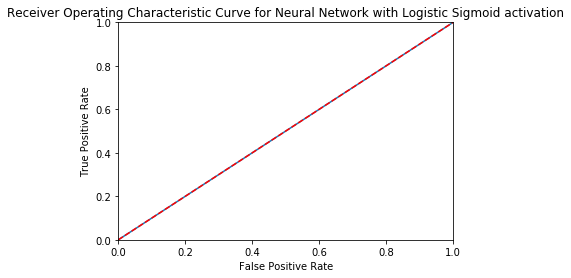


---------- Results Summary for Neural Network with tanh activation for the column: Age ----------

0.19120478630065918 seconds for  Neural Network with tanh activation  to train
Using Age as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.7425805571967459
Using Age as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7580439920014543

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4170          0
True >50k       1331          0

F1-score is: 0.0


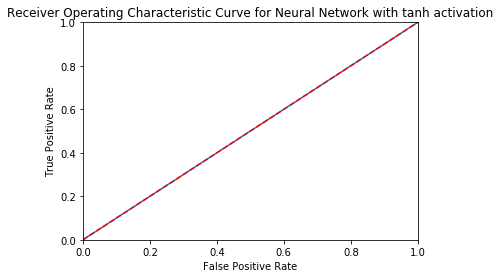


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: Age ----------

0.0017380714416503906 seconds for  Dummy Classifier that predicts most frequent  to train
Using Age as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.7425805571967459
Using Age as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0.7580439920014543

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4170          0
True >50k       1331          0

F1-score is: 0.0


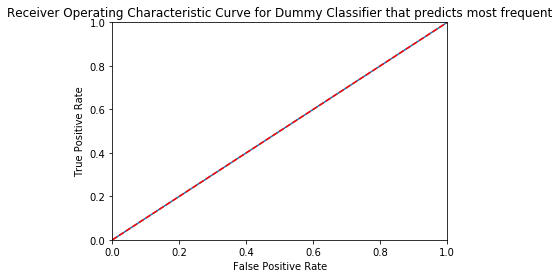


---------- Results Summary for Dummy Classifier that makes stratified predictions for the column: Age ----------

0.0018067359924316406 seconds for  Dummy Classifier that makes stratified predictions  to train
Using Age as a predictor for  Dummy Classifier that makes stratified predictions  we get train accuracy of:  0.6163704949325092
Using Age as a predictor for  Dummy Classifier that makes stratified predictions  we get test accuracy of:  0.6280676240683513

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3098       1072
True >50k        983        348

F1-score is: 0.2318181818181818


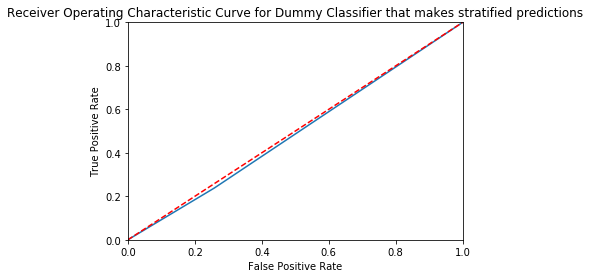


---------- Results Summary for Dummy Classifier that maximizes the prior for the column: Age ----------

0.0017237663269042969 seconds for  Dummy Classifier that maximizes the prior  to train
Using Age as a predictor for  Dummy Classifier that maximizes the prior  we get train accuracy of:  0.7425805571967459
Using Age as a predictor for  Dummy Classifier that maximizes the prior  we get test accuracy of:  0.7580439920014543

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4170          0
True >50k       1331          0

F1-score is: 0.0


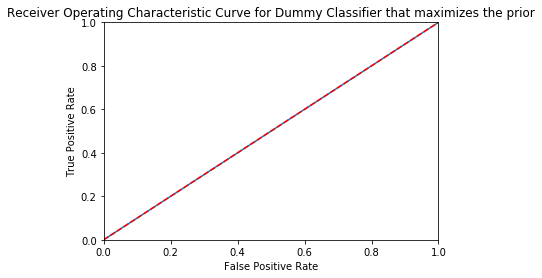


--------------- Returning Algorithm Results Summary for the feature: Education ---------------

---------- Results Summary for GaussianNB for the column: Education ----------

0.0025060176849365234 seconds for  GaussianNB  to train
Using Education as a predictor for  GaussianNB  we get train accuracy of:  0.7655319729127846
Using Education as a predictor for  GaussianNB  we get test accuracy of:  0.7796764224686421

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4000        170
True >50k       1042        289

F1-score is: 0.32290502793296094


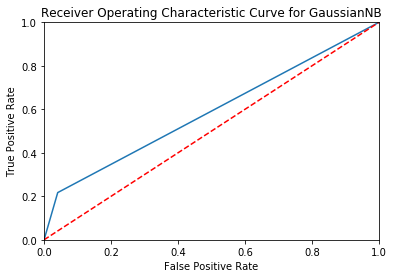


---------- Results Summary for SVM with Linear Kernel for the column: Education ----------

4.25839900970459 seconds for  SVM with Linear Kernel  to train
Using Education as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.7425805571967459
Using Education as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7581818181818182

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4170          0
True >50k       1331          0

F1-score is: 0.0


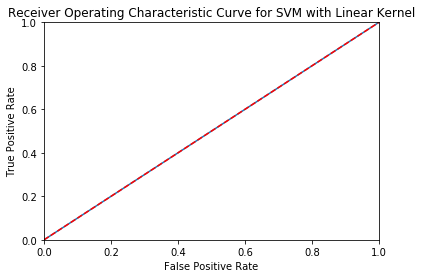


---------- Results Summary for SVM with Sigmoid Kernel for the column: Education ----------

5.493689060211182 seconds for  SVM with Sigmoid Kernel  to train
Using Education as a predictor for  SVM with Sigmoid Kernel  we get train accuracy of:  0.7655319729127846
Using Education as a predictor for  SVM with Sigmoid Kernel  we get test accuracy of:  0.79

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4000        170
True >50k       1042        289

F1-score is: 0.32290502793296094


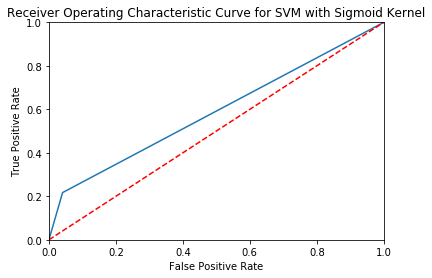


---------- Results Summary for SVM with Radial Basis Function Kernel for the column: Education ----------

6.598253965377808 seconds for  SVM with Radial Basis Function Kernel  to train
Using Education as a predictor for  SVM with Radial Basis Function Kernel  we get train accuracy of:  0.7655319729127846
Using Education as a predictor for  SVM with Radial Basis Function Kernel  we get test accuracy of:  0.7845454545454545

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4000        170
True >50k       1042        289

F1-score is: 0.32290502793296094


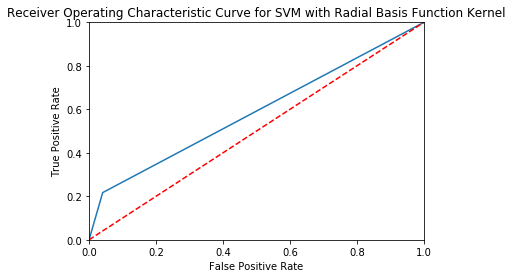


---------- Results Summary for Neural Network with ReLU activation for the column: Education ----------

0.04563617706298828 seconds for  Neural Network with ReLU activation  to train
Using Education as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.7425805571967459
Using Education as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7580439920014543

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4170          0
True >50k       1331          0

F1-score is: 0.0


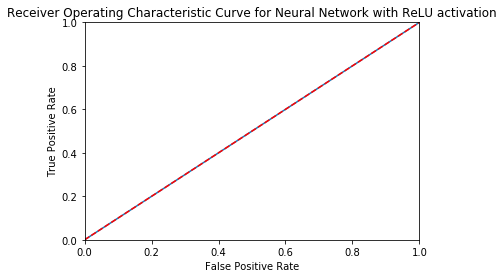


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Education ----------

0.30925893783569336 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Education as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.7655319729127846
Using Education as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7796764224686421

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4000        170
True >50k       1042        289

F1-score is: 0.32290502793296094


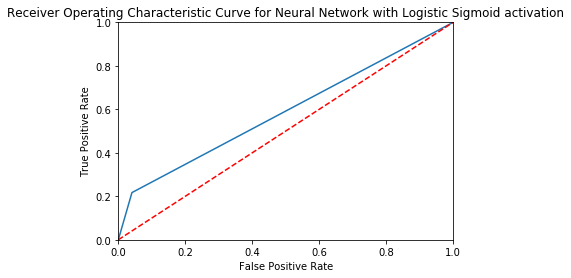


---------- Results Summary for Neural Network with tanh activation for the column: Education ----------

0.17005395889282227 seconds for  Neural Network with tanh activation  to train
Using Education as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.7655319729127846
Using Education as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7796764224686421

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4000        170
True >50k       1042        289

F1-score is: 0.32290502793296094


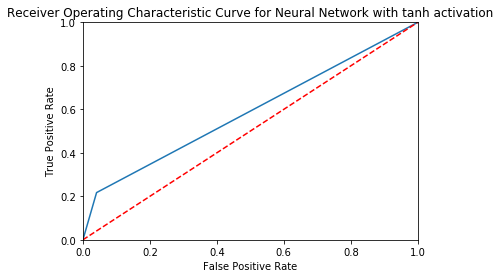


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: Education ----------

0.0018970966339111328 seconds for  Dummy Classifier that predicts most frequent  to train
Using Education as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.7425805571967459
Using Education as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0.7580439920014543

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4170          0
True >50k       1331          0

F1-score is: 0.0


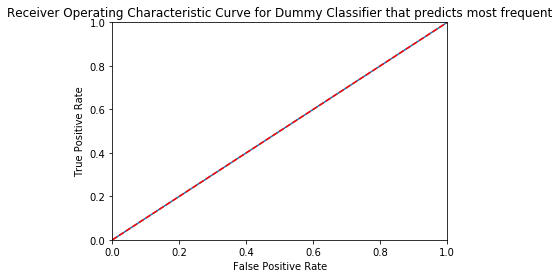


---------- Results Summary for Dummy Classifier that makes stratified predictions for the column: Education ----------

0.0020608901977539062 seconds for  Dummy Classifier that makes stratified predictions  to train
Using Education as a predictor for  Dummy Classifier that makes stratified predictions  we get train accuracy of:  0.6230059537335818
Using Education as a predictor for  Dummy Classifier that makes stratified predictions  we get test accuracy of:  0.6202508634793674

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3086       1084
True >50k        982        349

F1-score is: 0.2625368731563421


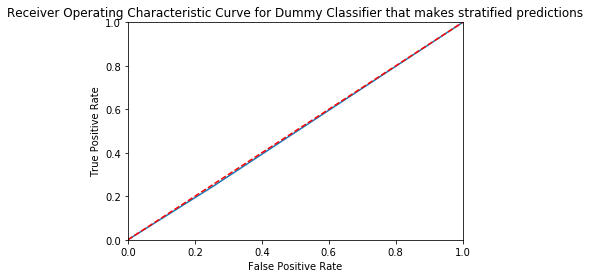


---------- Results Summary for Dummy Classifier that maximizes the prior for the column: Education ----------

0.001728057861328125 seconds for  Dummy Classifier that maximizes the prior  to train
Using Education as a predictor for  Dummy Classifier that maximizes the prior  we get train accuracy of:  0.7425805571967459
Using Education as a predictor for  Dummy Classifier that maximizes the prior  we get test accuracy of:  0.7580439920014543

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4170          0
True >50k       1331          0

F1-score is: 0.0


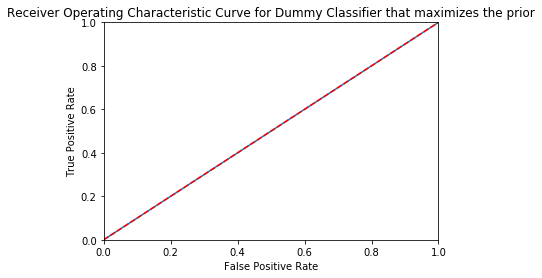


--------------- Returning Algorithm Results Summary for the feature: Capital Gain ---------------

---------- Results Summary for GaussianNB for the column: Capital Gain ----------

0.0023620128631591797 seconds for  GaussianNB  to train
Using Capital Gain as a predictor for  GaussianNB  we get train accuracy of:  0.7770758532927328
Using Capital Gain as a predictor for  GaussianNB  we get test accuracy of:  0.7913106707871296

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4066        104
True >50k       1044        287

F1-score is: 0.3333333333333333


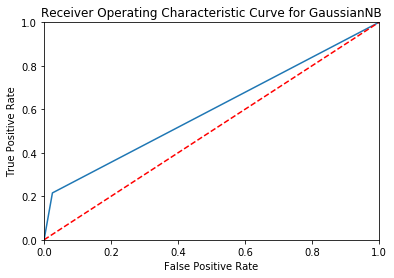


---------- Results Summary for SVM with Linear Kernel for the column: Capital Gain ----------

2.013554096221924 seconds for  SVM with Linear Kernel  to train
Using Capital Gain as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.7826660000908967
Using Capital Gain as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.8109090909090909

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4105         65
True >50k       1058        273

F1-score is: 0.3271420011983224


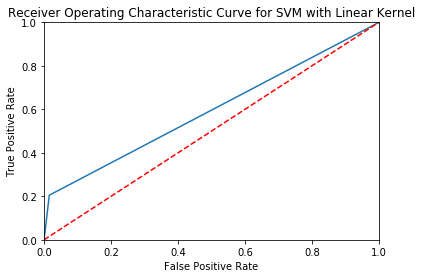


---------- Results Summary for SVM with Sigmoid Kernel for the column: Capital Gain ----------

3.4283299446105957 seconds for  SVM with Sigmoid Kernel  to train
Using Capital Gain as a predictor for  SVM with Sigmoid Kernel  we get train accuracy of:  0.7577148570649457
Using Capital Gain as a predictor for  SVM with Sigmoid Kernel  we get test accuracy of:  0.7918181818181819

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4012        158
True >50k       1079        252

F1-score is: 0.289488799540494


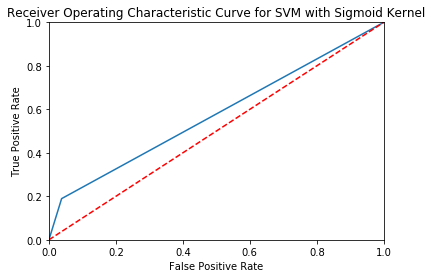


---------- Results Summary for SVM with Radial Basis Function Kernel for the column: Capital Gain ----------

2.939215898513794 seconds for  SVM with Radial Basis Function Kernel  to train
Using Capital Gain as a predictor for  SVM with Radial Basis Function Kernel  we get train accuracy of:  0.7862109712311958
Using Capital Gain as a predictor for  SVM with Radial Basis Function Kernel  we get test accuracy of:  0.8063636363636364

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4159         11
True >50k       1094        237

F1-score is: 0.3001899936668777


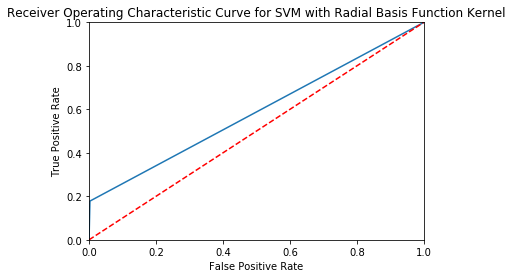


---------- Results Summary for Neural Network with ReLU activation for the column: Capital Gain ----------

0.27222204208374023 seconds for  Neural Network with ReLU activation  to train
Using Capital Gain as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.7868017997545789
Using Capital Gain as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7991274313761134

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4141         29
True >50k       1076        255

F1-score is: 0.31578947368421056


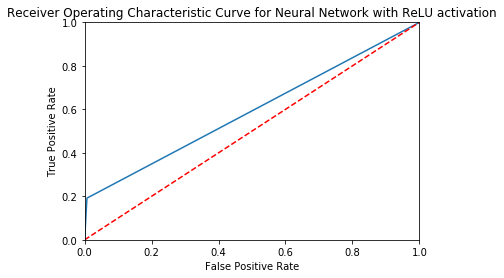


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Capital Gain ----------

0.27931809425354004 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Capital Gain as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.7868017997545789
Using Capital Gain as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7991274313761134

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4141         29
True >50k       1076        255

F1-score is: 0.31578947368421056


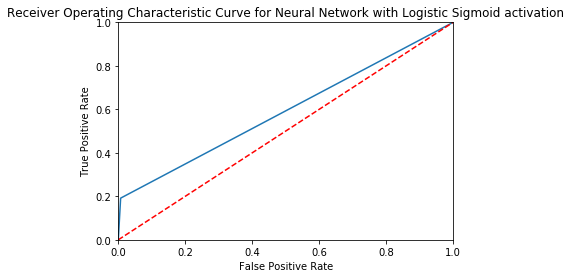


---------- Results Summary for Neural Network with tanh activation for the column: Capital Gain ----------

0.1092228889465332 seconds for  Neural Network with tanh activation  to train
Using Capital Gain as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.7856655910557652
Using Capital Gain as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7985820759861844

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4155         15
True >50k       1093        238

F1-score is: 0.3005050505050505


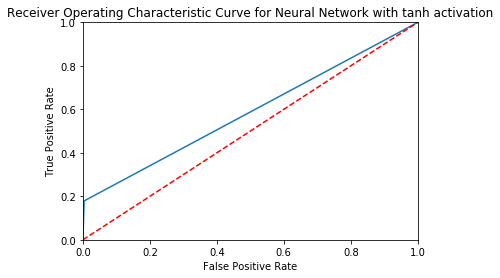


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: Capital Gain ----------

0.002218008041381836 seconds for  Dummy Classifier that predicts most frequent  to train
Using Capital Gain as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.7425805571967459
Using Capital Gain as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0.7580439920014543

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4170          0
True >50k       1331          0

F1-score is: 0.0


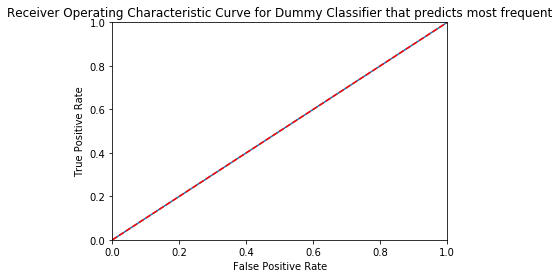


---------- Results Summary for Dummy Classifier that makes stratified predictions for the column: Capital Gain ----------

0.0021049976348876953 seconds for  Dummy Classifier that makes stratified predictions  to train
Using Capital Gain as a predictor for  Dummy Classifier that makes stratified predictions  we get train accuracy of:  0.6162341498886516
Using Capital Gain as a predictor for  Dummy Classifier that makes stratified predictions  we get test accuracy of:  0.6189783675695328

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3141       1029
True >50k       1027        304

F1-score is: 0.24055232558139533


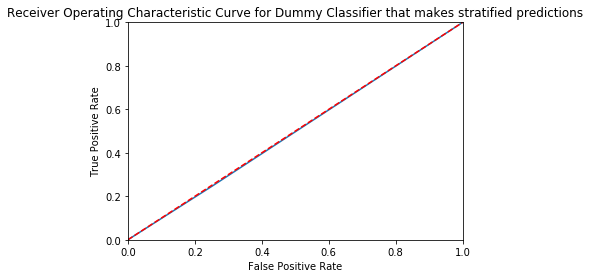


---------- Results Summary for Dummy Classifier that maximizes the prior for the column: Capital Gain ----------

0.002074718475341797 seconds for  Dummy Classifier that maximizes the prior  to train
Using Capital Gain as a predictor for  Dummy Classifier that maximizes the prior  we get train accuracy of:  0.7425805571967459
Using Capital Gain as a predictor for  Dummy Classifier that maximizes the prior  we get test accuracy of:  0.7580439920014543

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4170          0
True >50k       1331          0

F1-score is: 0.0


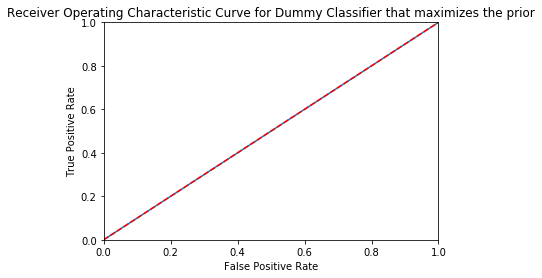


--------------- Returning Algorithm Results Summary for the feature: Capital Loss ---------------

---------- Results Summary for GaussianNB for the column: Capital Loss ----------

0.002223968505859375 seconds for  GaussianNB  to train
Using Capital Loss as a predictor for  GaussianNB  we get train accuracy of:  0.745716493205472
Using Capital Loss as a predictor for  GaussianNB  we get test accuracy of:  0.7576804217415015

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4037        133
True >50k       1200        131

F1-score is: 0.16426332288401255


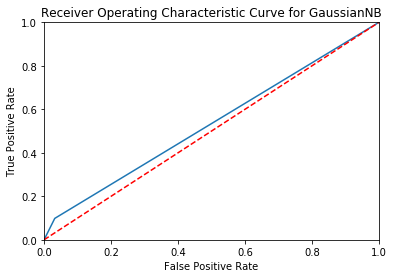


---------- Results Summary for SVM with Linear Kernel for the column: Capital Loss ----------

2.2040441036224365 seconds for  SVM with Linear Kernel  to train
Using Capital Loss as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.7461255283370449
Using Capital Loss as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7602179836512262

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4038        132
True >50k       1200        131

F1-score is: 0.164366373902133


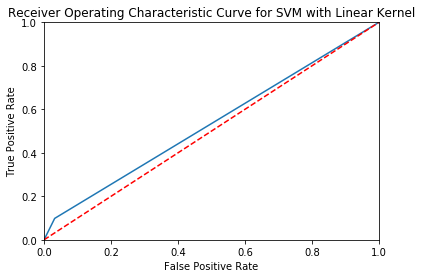


---------- Results Summary for SVM with Sigmoid Kernel for the column: Capital Loss ----------

4.0394392013549805 seconds for  SVM with Sigmoid Kernel  to train
Using Capital Loss as a predictor for  SVM with Sigmoid Kernel  we get train accuracy of:  0.743080489024224
Using Capital Loss as a predictor for  SVM with Sigmoid Kernel  we get test accuracy of:  0.7572727272727273

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4055        115
True >50k       1227        104

F1-score is: 0.1341935483870968


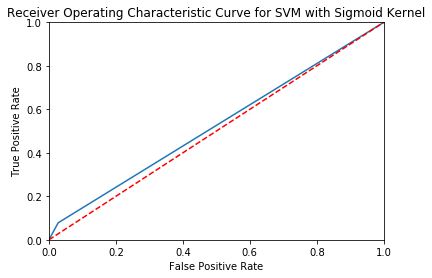


---------- Results Summary for SVM with Radial Basis Function Kernel for the column: Capital Loss ----------

3.139455795288086 seconds for  SVM with Radial Basis Function Kernel  to train
Using Capital Loss as a predictor for  SVM with Radial Basis Function Kernel  we get train accuracy of:  0.7589874108076171
Using Capital Loss as a predictor for  SVM with Radial Basis Function Kernel  we get test accuracy of:  0.7763636363636364

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4123         47
True >50k       1217        114

F1-score is: 0.15281501340482573


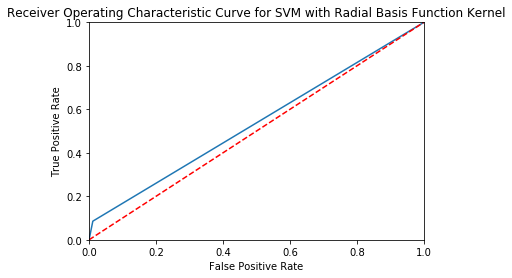


---------- Results Summary for Neural Network with ReLU activation for the column: Capital Loss ----------

0.04499006271362305 seconds for  Neural Network with ReLU activation  to train
Using Capital Loss as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.7425805571967459
Using Capital Loss as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7580439920014543

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4170          0
True >50k       1331          0

F1-score is: 0.0


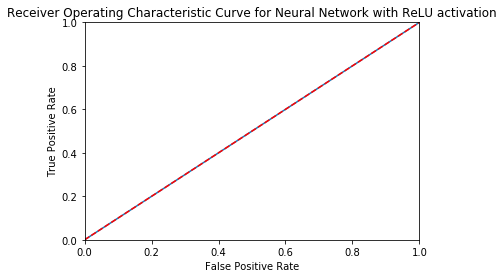


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Capital Loss ----------

0.25696301460266113 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Capital Loss as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.7579420988047084
Using Capital Loss as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7691328849300128

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4107         63
True >50k       1207        124

F1-score is: 0.16337285902503293


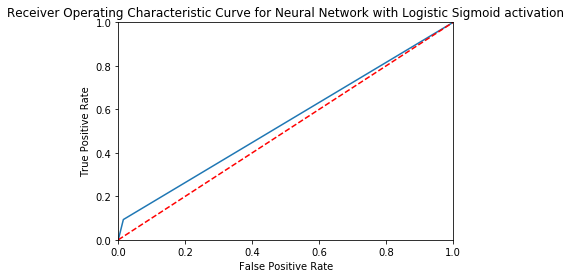


---------- Results Summary for Neural Network with tanh activation for the column: Capital Loss ----------

0.39490818977355957 seconds for  Neural Network with tanh activation  to train
Using Capital Loss as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.7579420988047084
Using Capital Loss as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7691328849300128

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4107         63
True >50k       1207        124

F1-score is: 0.16337285902503293


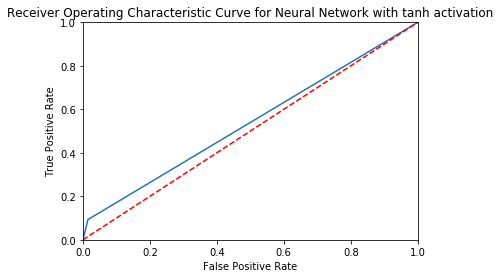


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: Capital Loss ----------

0.001750946044921875 seconds for  Dummy Classifier that predicts most frequent  to train
Using Capital Loss as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.7425805571967459
Using Capital Loss as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0.7580439920014543

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4170          0
True >50k       1331          0

F1-score is: 0.0


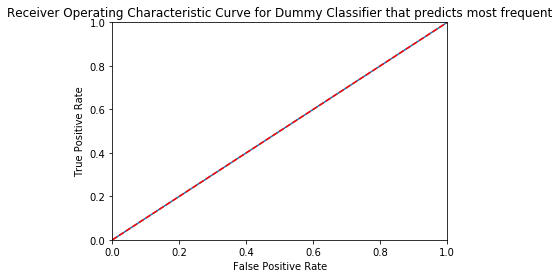


---------- Results Summary for Dummy Classifier that makes stratified predictions for the column: Capital Loss ----------

0.0017528533935546875 seconds for  Dummy Classifier that makes stratified predictions  to train
Using Capital Loss as a predictor for  Dummy Classifier that makes stratified predictions  we get train accuracy of:  0.6179611871108486
Using Capital Loss as a predictor for  Dummy Classifier that makes stratified predictions  we get test accuracy of:  0.6211597891292492

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3093       1077
True >50k       1008        323

F1-score is: 0.24255788313120175


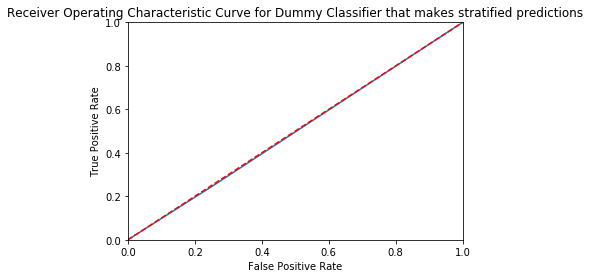


---------- Results Summary for Dummy Classifier that maximizes the prior for the column: Capital Loss ----------

0.0017619132995605469 seconds for  Dummy Classifier that maximizes the prior  to train
Using Capital Loss as a predictor for  Dummy Classifier that maximizes the prior  we get train accuracy of:  0.7425805571967459
Using Capital Loss as a predictor for  Dummy Classifier that maximizes the prior  we get test accuracy of:  0.7580439920014543

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4170          0
True >50k       1331          0

F1-score is: 0.0


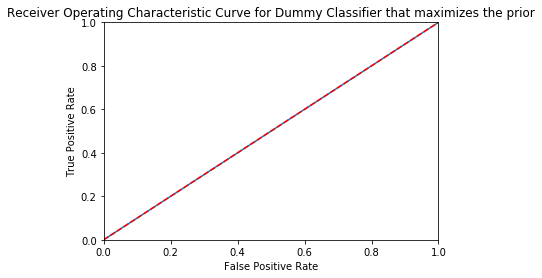


--------------- Returning Algorithm Results Summary for the feature: Hours Per Week ---------------

---------- Results Summary for GaussianNB for the column: Hours Per Week ----------

0.002789020538330078 seconds for  GaussianNB  to train
Using Hours Per Week as a predictor for  GaussianNB  we get train accuracy of:  0.7425805571967459
Using Hours Per Week as a predictor for  GaussianNB  we get test accuracy of:  0.7580439920014543

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4170          0
True >50k       1331          0

F1-score is: 0.0


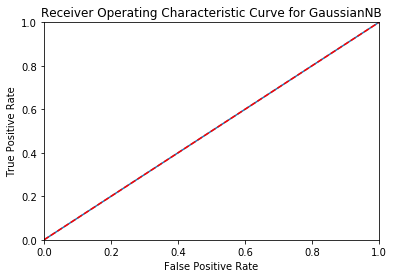


---------- Results Summary for SVM with Linear Kernel for the column: Hours Per Week ----------

5.00573205947876 seconds for  SVM with Linear Kernel  to train
Using Hours Per Week as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.7425805571967459
Using Hours Per Week as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7581818181818182

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4170          0
True >50k       1331          0

F1-score is: 0.0


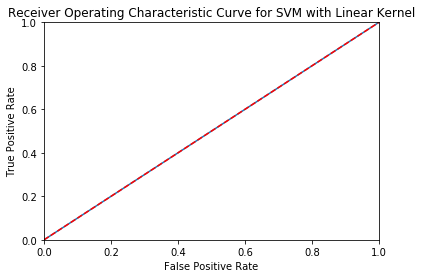


---------- Results Summary for SVM with Sigmoid Kernel for the column: Hours Per Week ----------

5.82397985458374 seconds for  SVM with Sigmoid Kernel  to train
Using Hours Per Week as a predictor for  SVM with Sigmoid Kernel  we get train accuracy of:  0.6676816797709403
Using Hours Per Week as a predictor for  SVM with Sigmoid Kernel  we get test accuracy of:  0.6963636363636364

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3284        886
True >50k        884        447

F1-score is: 0.33558558558558554


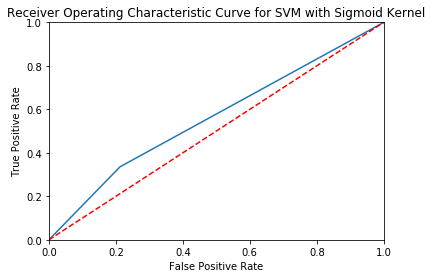


---------- Results Summary for SVM with Radial Basis Function Kernel for the column: Hours Per Week ----------

6.010361909866333 seconds for  SVM with Radial Basis Function Kernel  to train
Using Hours Per Week as a predictor for  SVM with Radial Basis Function Kernel  we get train accuracy of:  0.7425805571967459
Using Hours Per Week as a predictor for  SVM with Radial Basis Function Kernel  we get test accuracy of:  0.7581818181818182

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4170          0
True >50k       1331          0

F1-score is: 0.0


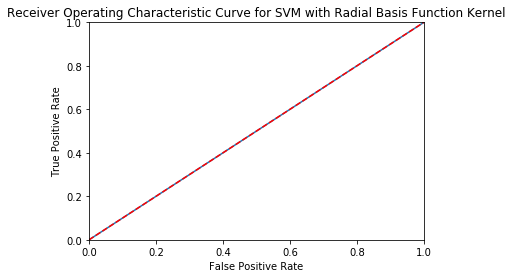


---------- Results Summary for Neural Network with ReLU activation for the column: Hours Per Week ----------

0.3419520854949951 seconds for  Neural Network with ReLU activation  to train
Using Hours Per Week as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.7425805571967459
Using Hours Per Week as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7580439920014543

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4170          0
True >50k       1331          0

F1-score is: 0.0


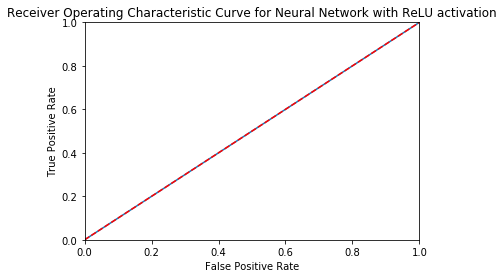


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Hours Per Week ----------

0.17547202110290527 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Hours Per Week as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.7425805571967459
Using Hours Per Week as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7580439920014543

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4170          0
True >50k       1331          0

F1-score is: 0.0


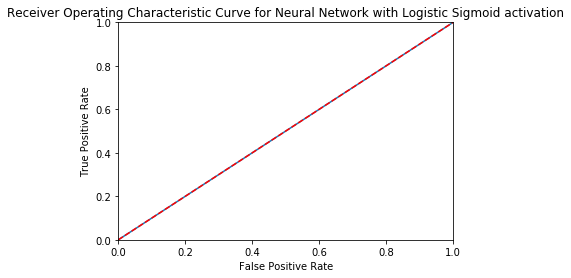


---------- Results Summary for Neural Network with tanh activation for the column: Hours Per Week ----------

0.24280905723571777 seconds for  Neural Network with tanh activation  to train
Using Hours Per Week as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.7425805571967459
Using Hours Per Week as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7580439920014543

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4170          0
True >50k       1331          0

F1-score is: 0.0


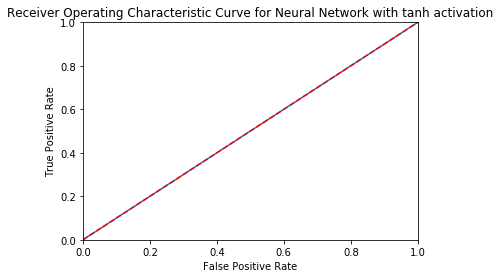


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: Hours Per Week ----------

0.0025589466094970703 seconds for  Dummy Classifier that predicts most frequent  to train
Using Hours Per Week as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.7425805571967459
Using Hours Per Week as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0.7580439920014543

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4170          0
True >50k       1331          0

F1-score is: 0.0


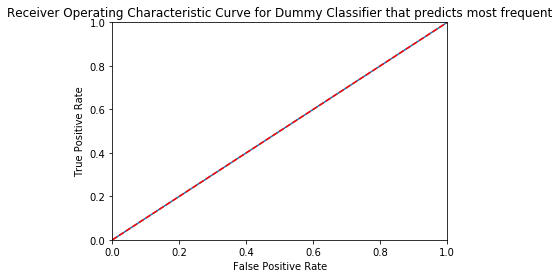


---------- Results Summary for Dummy Classifier that makes stratified predictions for the column: Hours Per Week ----------

0.002359151840209961 seconds for  Dummy Classifier that makes stratified predictions  to train
Using Hours Per Week as a predictor for  Dummy Classifier that makes stratified predictions  we get train accuracy of:  0.6140071808389765
Using Hours Per Week as a predictor for  Dummy Classifier that makes stratified predictions  we get test accuracy of:  0.6362479549172878

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3079       1091
True >50k        998        333

F1-score is: 0.23985374771480802


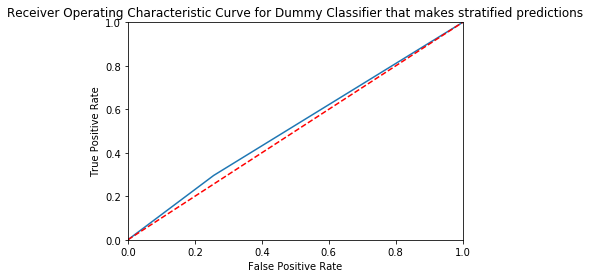


---------- Results Summary for Dummy Classifier that maximizes the prior for the column: Hours Per Week ----------

0.0015468597412109375 seconds for  Dummy Classifier that maximizes the prior  to train
Using Hours Per Week as a predictor for  Dummy Classifier that maximizes the prior  we get train accuracy of:  0.7425805571967459
Using Hours Per Week as a predictor for  Dummy Classifier that maximizes the prior  we get test accuracy of:  0.7580439920014543

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4170          0
True >50k       1331          0

F1-score is: 0.0


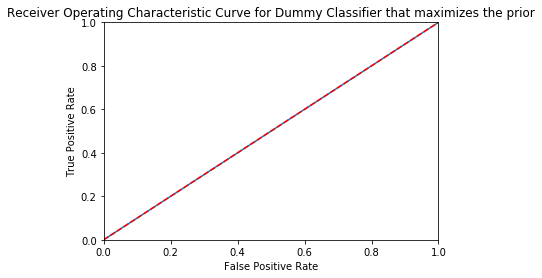


--------------- Returning Algorithm Results Summary for the feature: Workclass ---------------

---------- Results Summary for GaussianNB for the column: Workclass ----------

0.005051851272583008 seconds for  GaussianNB  to train
Using Workclass as a predictor for  GaussianNB  we get train accuracy of:  0.2578739262827796
Using Workclass as a predictor for  GaussianNB  we get test accuracy of:  0.24250136338847483

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k          3       4167
True >50k          0       1331

F1-score is: 0.3898081710352907


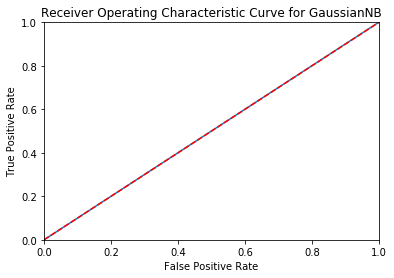


---------- Results Summary for SVM with Linear Kernel for the column: Workclass ----------

3.51111102104187 seconds for  SVM with Linear Kernel  to train
Using Workclass as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.7467163568604281
Using Workclass as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.77

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4093         77
True >50k       1220        111

F1-score is: 0.14614878209348256


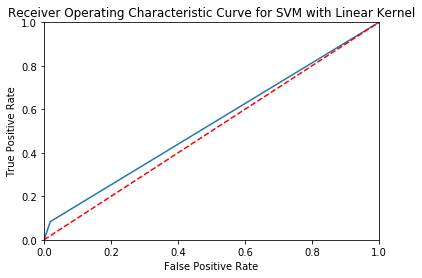


---------- Results Summary for SVM with Sigmoid Kernel for the column: Workclass ----------

6.904025077819824 seconds for  SVM with Sigmoid Kernel  to train
Using Workclass as a predictor for  SVM with Sigmoid Kernel  we get train accuracy of:  0.7467163568604281
Using Workclass as a predictor for  SVM with Sigmoid Kernel  we get test accuracy of:  0.77

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4093         77
True >50k       1220        111

F1-score is: 0.14614878209348256


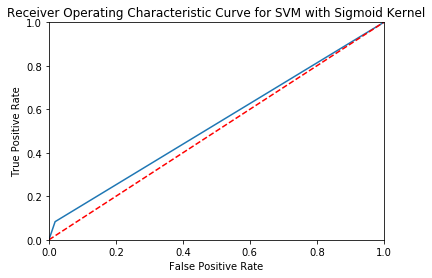


---------- Results Summary for SVM with Radial Basis Function Kernel for the column: Workclass ----------

6.214884996414185 seconds for  SVM with Radial Basis Function Kernel  to train
Using Workclass as a predictor for  SVM with Radial Basis Function Kernel  we get train accuracy of:  0.7467163568604281
Using Workclass as a predictor for  SVM with Radial Basis Function Kernel  we get test accuracy of:  0.77

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4093         77
True >50k       1220        111

F1-score is: 0.14614878209348256


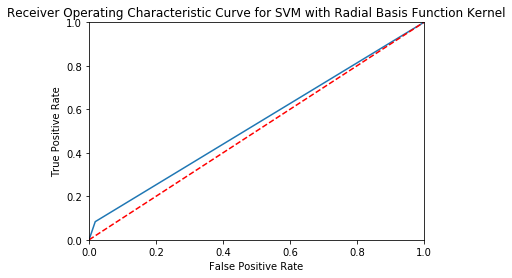


---------- Results Summary for Neural Network with ReLU activation for the column: Workclass ----------

0.12190985679626465 seconds for  Neural Network with ReLU activation  to train
Using Workclass as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.7425805571967459
Using Workclass as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7580439920014543

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4170          0
True >50k       1331          0

F1-score is: 0.0


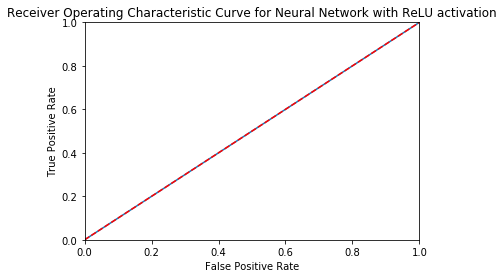


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Workclass ----------

0.19547796249389648 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Workclass as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.7467163568604281
Using Workclass as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7642246864206508

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4093         77
True >50k       1220        111

F1-score is: 0.14614878209348256


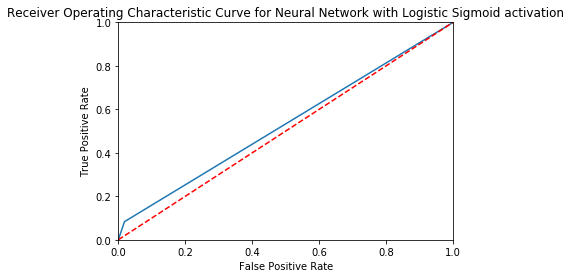


---------- Results Summary for Neural Network with tanh activation for the column: Workclass ----------

0.2050480842590332 seconds for  Neural Network with tanh activation  to train
Using Workclass as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.7467163568604281
Using Workclass as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7642246864206508

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4093         77
True >50k       1220        111

F1-score is: 0.14614878209348256


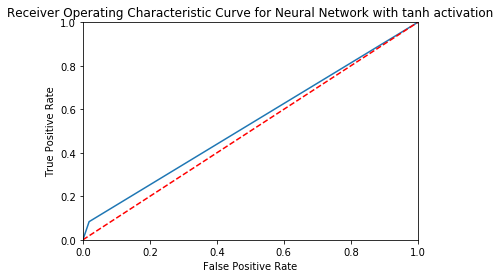


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: Workclass ----------

0.002077817916870117 seconds for  Dummy Classifier that predicts most frequent  to train
Using Workclass as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.7425805571967459
Using Workclass as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0.7580439920014543

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4170          0
True >50k       1331          0

F1-score is: 0.0


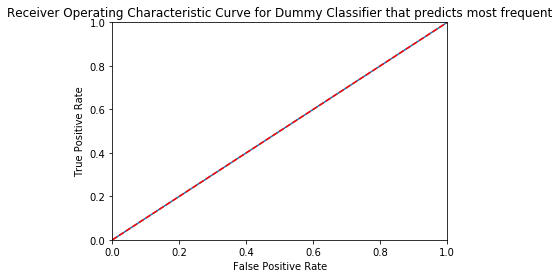


---------- Results Summary for Dummy Classifier that makes stratified predictions for the column: Workclass ----------

0.0019948482513427734 seconds for  Dummy Classifier that makes stratified predictions  to train
Using Workclass as a predictor for  Dummy Classifier that makes stratified predictions  we get train accuracy of:  0.6174612552833705
Using Workclass as a predictor for  Dummy Classifier that makes stratified predictions  we get test accuracy of:  0.6157062352299582

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3070       1100
True >50k        964        367

F1-score is: 0.24926470588235294


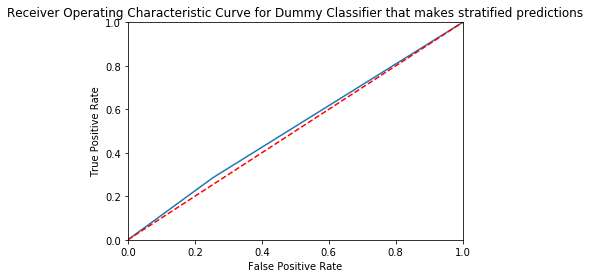


---------- Results Summary for Dummy Classifier that maximizes the prior for the column: Workclass ----------

0.0016570091247558594 seconds for  Dummy Classifier that maximizes the prior  to train
Using Workclass as a predictor for  Dummy Classifier that maximizes the prior  we get train accuracy of:  0.7425805571967459
Using Workclass as a predictor for  Dummy Classifier that maximizes the prior  we get test accuracy of:  0.7580439920014543

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4170          0
True >50k       1331          0

F1-score is: 0.0


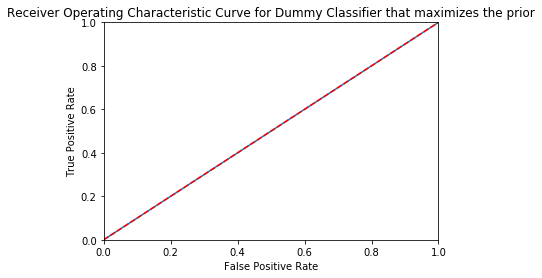


--------------- Returning Algorithm Results Summary for the feature: Marital Status ---------------

---------- Results Summary for GaussianNB for the column: Marital Status ----------

0.0046672821044921875 seconds for  GaussianNB  to train
Using Marital Status as a predictor for  GaussianNB  we get train accuracy of:  0.7179021042585102
Using Marital Status as a predictor for  GaussianNB  we get test accuracy of:  0.696600618069442

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       2718       1452
True >50k        217       1114

F1-score is: 0.5717218373107519


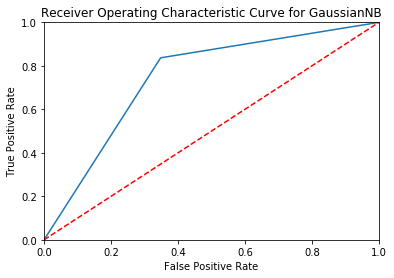


---------- Results Summary for SVM with Linear Kernel for the column: Marital Status ----------

4.746789932250977 seconds for  SVM with Linear Kernel  to train
Using Marital Status as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.7425805571967459
Using Marital Status as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7581818181818182

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4170          0
True >50k       1331          0

F1-score is: 0.0


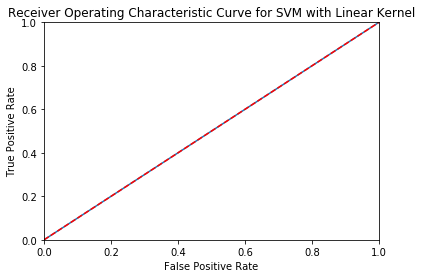


---------- Results Summary for SVM with Sigmoid Kernel for the column: Marital Status ----------

7.736691951751709 seconds for  SVM with Sigmoid Kernel  to train
Using Marital Status as a predictor for  SVM with Sigmoid Kernel  we get train accuracy of:  0.7425805571967459
Using Marital Status as a predictor for  SVM with Sigmoid Kernel  we get test accuracy of:  0.7581818181818182

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4170          0
True >50k       1331          0

F1-score is: 0.0


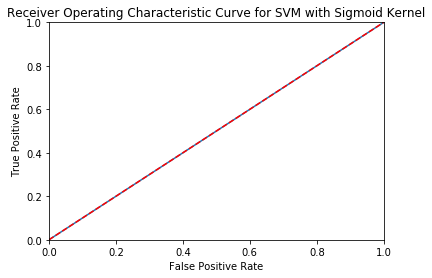


---------- Results Summary for SVM with Radial Basis Function Kernel for the column: Marital Status ----------

7.091558933258057 seconds for  SVM with Radial Basis Function Kernel  to train
Using Marital Status as a predictor for  SVM with Radial Basis Function Kernel  we get train accuracy of:  0.7425805571967459
Using Marital Status as a predictor for  SVM with Radial Basis Function Kernel  we get test accuracy of:  0.7581818181818182

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4170          0
True >50k       1331          0

F1-score is: 0.0


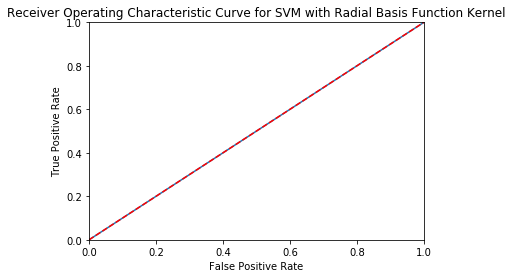


---------- Results Summary for Neural Network with ReLU activation for the column: Marital Status ----------

0.11590719223022461 seconds for  Neural Network with ReLU activation  to train
Using Marital Status as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.7425805571967459
Using Marital Status as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7580439920014543

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4170          0
True >50k       1331          0

F1-score is: 0.0


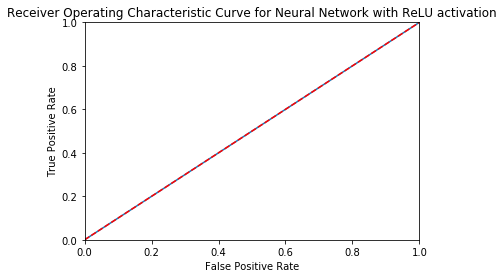


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Marital Status ----------

0.19104576110839844 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Marital Status as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.7425805571967459
Using Marital Status as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7580439920014543

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4170          0
True >50k       1331          0

F1-score is: 0.0


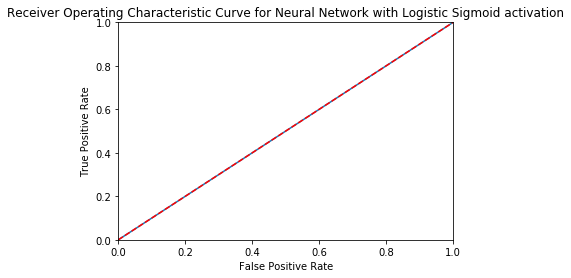


---------- Results Summary for Neural Network with tanh activation for the column: Marital Status ----------

0.2754628658294678 seconds for  Neural Network with tanh activation  to train
Using Marital Status as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.7425805571967459
Using Marital Status as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7580439920014543

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4170          0
True >50k       1331          0

F1-score is: 0.0


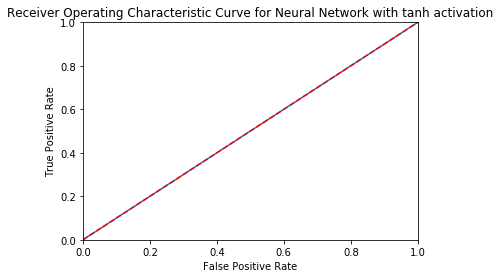


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: Marital Status ----------

0.0021848678588867188 seconds for  Dummy Classifier that predicts most frequent  to train
Using Marital Status as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.7425805571967459
Using Marital Status as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0.7580439920014543

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4170          0
True >50k       1331          0

F1-score is: 0.0


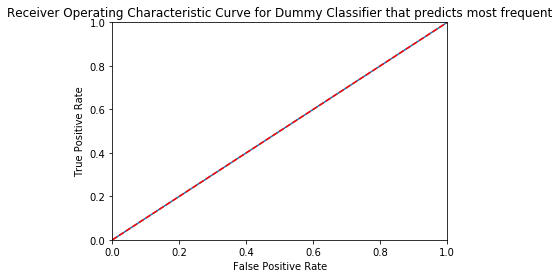


---------- Results Summary for Dummy Classifier that makes stratified predictions for the column: Marital Status ----------

0.0020232200622558594 seconds for  Dummy Classifier that makes stratified predictions  to train
Using Marital Status as a predictor for  Dummy Classifier that makes stratified predictions  we get train accuracy of:  0.6190973958096623
Using Marital Status as a predictor for  Dummy Classifier that makes stratified predictions  we get test accuracy of:  0.6255226322486821

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3107       1063
True >50k        998        333

F1-score is: 0.24752837788355914


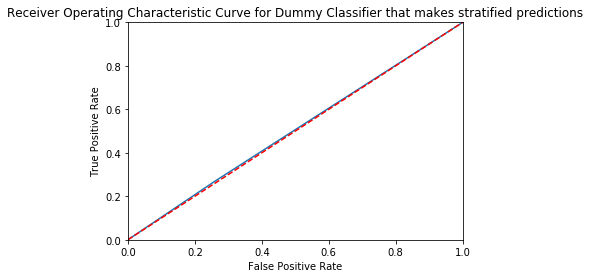


---------- Results Summary for Dummy Classifier that maximizes the prior for the column: Marital Status ----------

0.001664876937866211 seconds for  Dummy Classifier that maximizes the prior  to train
Using Marital Status as a predictor for  Dummy Classifier that maximizes the prior  we get train accuracy of:  0.7425805571967459
Using Marital Status as a predictor for  Dummy Classifier that maximizes the prior  we get test accuracy of:  0.7580439920014543

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4170          0
True >50k       1331          0

F1-score is: 0.0


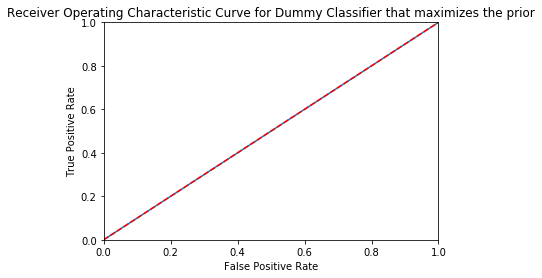


--------------- Returning Algorithm Results Summary for the feature: Occupation ---------------

---------- Results Summary for GaussianNB for the column: Occupation ----------

0.009517908096313477 seconds for  GaussianNB  to train
Using Occupation as a predictor for  GaussianNB  we get train accuracy of:  0.41676135072490117
Using Occupation as a predictor for  GaussianNB  we get test accuracy of:  0.39720050899836395

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k        919       3251
True >50k         65       1266

F1-score is: 0.43296853625171


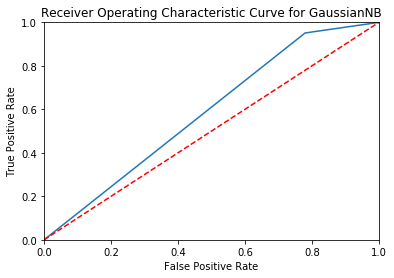


---------- Results Summary for SVM with Linear Kernel for the column: Occupation ----------

6.480258226394653 seconds for  SVM with Linear Kernel  to train
Using Occupation as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.7425805571967459
Using Occupation as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7581818181818182

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4170          0
True >50k       1331          0

F1-score is: 0.0


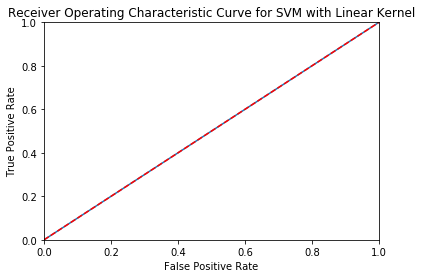


---------- Results Summary for SVM with Sigmoid Kernel for the column: Occupation ----------

7.993719100952148 seconds for  SVM with Sigmoid Kernel  to train
Using Occupation as a predictor for  SVM with Sigmoid Kernel  we get train accuracy of:  0.7425805571967459
Using Occupation as a predictor for  SVM with Sigmoid Kernel  we get test accuracy of:  0.7581818181818182

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4170          0
True >50k       1331          0

F1-score is: 0.0


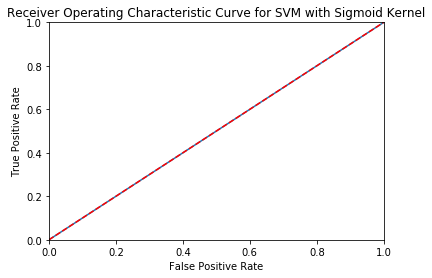


---------- Results Summary for SVM with Radial Basis Function Kernel for the column: Occupation ----------

9.72956371307373 seconds for  SVM with Radial Basis Function Kernel  to train
Using Occupation as a predictor for  SVM with Radial Basis Function Kernel  we get train accuracy of:  0.7425805571967459
Using Occupation as a predictor for  SVM with Radial Basis Function Kernel  we get test accuracy of:  0.7581818181818182

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4170          0
True >50k       1331          0

F1-score is: 0.0


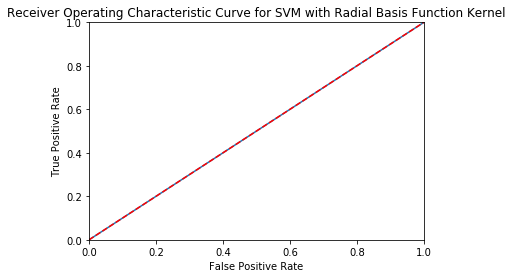


---------- Results Summary for Neural Network with ReLU activation for the column: Occupation ----------

0.7552928924560547 seconds for  Neural Network with ReLU activation  to train
Using Occupation as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.7425805571967459
Using Occupation as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7580439920014543

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4170          0
True >50k       1331          0

F1-score is: 0.0


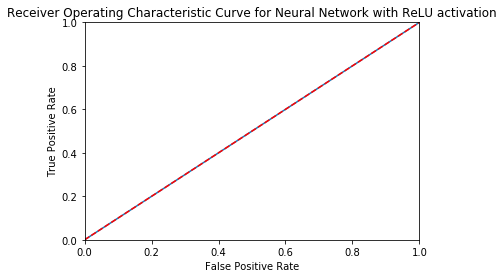


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Occupation ----------

0.297619104385376 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Occupation as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.7425805571967459
Using Occupation as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7580439920014543

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4170          0
True >50k       1331          0

F1-score is: 0.0


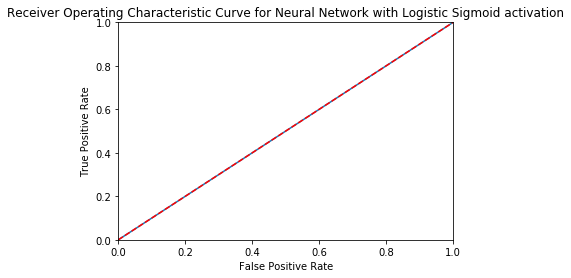


---------- Results Summary for Neural Network with tanh activation for the column: Occupation ----------

0.4086289405822754 seconds for  Neural Network with tanh activation  to train
Using Occupation as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.7425805571967459
Using Occupation as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7580439920014543

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4170          0
True >50k       1331          0

F1-score is: 0.0


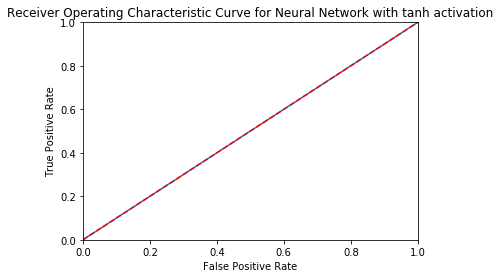


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: Occupation ----------

0.002337932586669922 seconds for  Dummy Classifier that predicts most frequent  to train
Using Occupation as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.7425805571967459
Using Occupation as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0.7580439920014543

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4170          0
True >50k       1331          0

F1-score is: 0.0


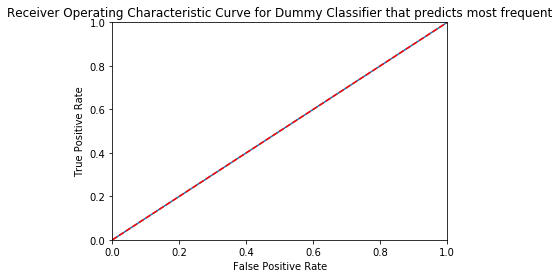


---------- Results Summary for Dummy Classifier that makes stratified predictions for the column: Occupation ----------

0.0028548240661621094 seconds for  Dummy Classifier that makes stratified predictions  to train
Using Occupation as a predictor for  Dummy Classifier that makes stratified predictions  we get train accuracy of:  0.6178702904149435
Using Occupation as a predictor for  Dummy Classifier that makes stratified predictions  we get test accuracy of:  0.6264315578985639

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3111       1059
True >50k        956        375

F1-score is: 0.24990945309670412


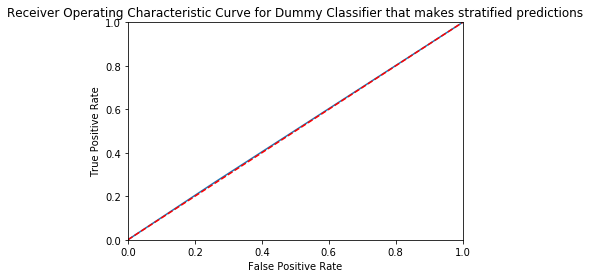


---------- Results Summary for Dummy Classifier that maximizes the prior for the column: Occupation ----------

0.0022449493408203125 seconds for  Dummy Classifier that maximizes the prior  to train
Using Occupation as a predictor for  Dummy Classifier that maximizes the prior  we get train accuracy of:  0.7425805571967459
Using Occupation as a predictor for  Dummy Classifier that maximizes the prior  we get test accuracy of:  0.7580439920014543

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4170          0
True >50k       1331          0

F1-score is: 0.0


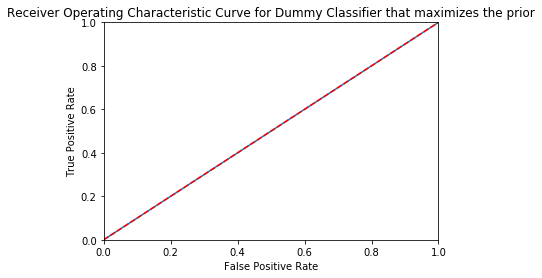


--------------- Returning Algorithm Results Summary for the feature: Relationship ---------------

---------- Results Summary for GaussianNB for the column: Relationship ----------

0.006681919097900391 seconds for  GaussianNB  to train
Using Relationship as a predictor for  GaussianNB  we get train accuracy of:  0.7215379720947144
Using Relationship as a predictor for  GaussianNB  we get test accuracy of:  0.6993273950190875

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       2739       1431
True >50k        223       1108

F1-score is: 0.572609819121447


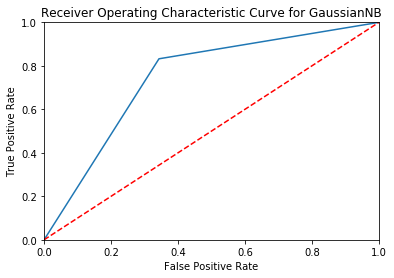


---------- Results Summary for SVM with Linear Kernel for the column: Relationship ----------

4.553220748901367 seconds for  SVM with Linear Kernel  to train
Using Relationship as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.7428986956324137
Using Relationship as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7636363636363637

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4057        113
True >50k       1206        125

F1-score is: 0.15933715742511154


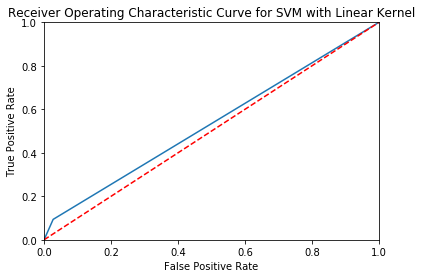


---------- Results Summary for SVM with Sigmoid Kernel for the column: Relationship ----------

7.428624868392944 seconds for  SVM with Sigmoid Kernel  to train
Using Relationship as a predictor for  SVM with Sigmoid Kernel  we get train accuracy of:  0.7428986956324137
Using Relationship as a predictor for  SVM with Sigmoid Kernel  we get test accuracy of:  0.7636363636363637

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4057        113
True >50k       1206        125

F1-score is: 0.15933715742511154


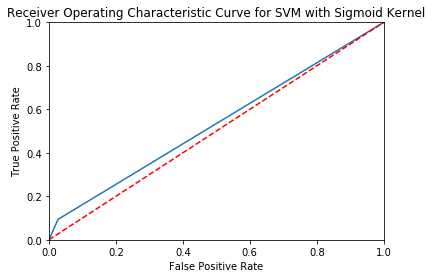


---------- Results Summary for SVM with Radial Basis Function Kernel for the column: Relationship ----------

6.980024099349976 seconds for  SVM with Radial Basis Function Kernel  to train
Using Relationship as a predictor for  SVM with Radial Basis Function Kernel  we get train accuracy of:  0.7428986956324137
Using Relationship as a predictor for  SVM with Radial Basis Function Kernel  we get test accuracy of:  0.7636363636363637

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4057        113
True >50k       1206        125

F1-score is: 0.15933715742511154


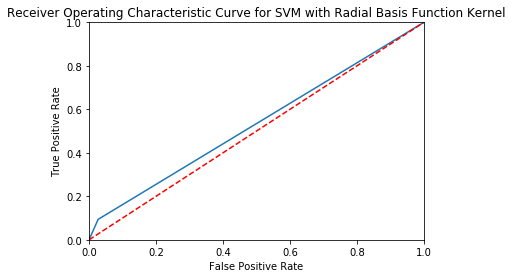


---------- Results Summary for Neural Network with ReLU activation for the column: Relationship ----------

0.43351197242736816 seconds for  Neural Network with ReLU activation  to train
Using Relationship as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.7428986956324137
Using Relationship as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7602254135611707

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4057        113
True >50k       1206        125

F1-score is: 0.15933715742511154


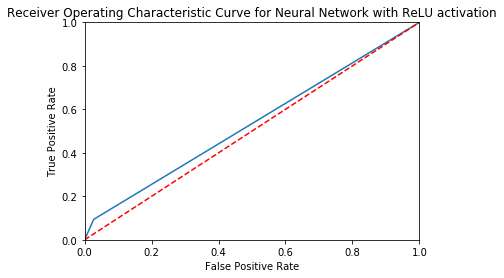


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Relationship ----------

0.29131197929382324 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Relationship as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.7425805571967459
Using Relationship as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7580439920014543

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4170          0
True >50k       1331          0

F1-score is: 0.0


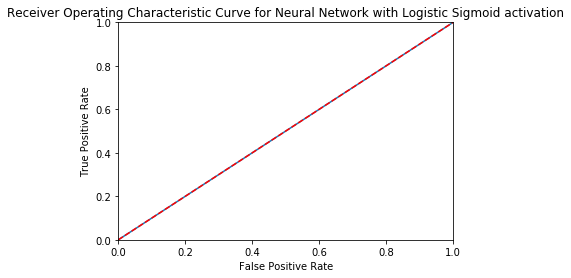


---------- Results Summary for Neural Network with tanh activation for the column: Relationship ----------

0.33214616775512695 seconds for  Neural Network with tanh activation  to train
Using Relationship as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.7428986956324137
Using Relationship as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7602254135611707

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4057        113
True >50k       1206        125

F1-score is: 0.15933715742511154


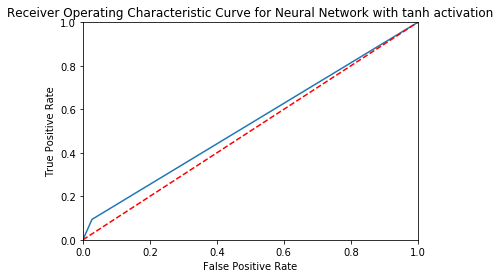


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: Relationship ----------

0.002112150192260742 seconds for  Dummy Classifier that predicts most frequent  to train
Using Relationship as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.7425805571967459
Using Relationship as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0.7580439920014543

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4170          0
True >50k       1331          0

F1-score is: 0.0


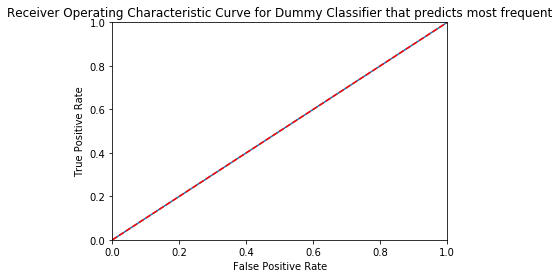


---------- Results Summary for Dummy Classifier that makes stratified predictions for the column: Relationship ----------

0.0018260478973388672 seconds for  Dummy Classifier that makes stratified predictions  to train
Using Relationship as a predictor for  Dummy Classifier that makes stratified predictions  we get train accuracy of:  0.6200063627687133
Using Relationship as a predictor for  Dummy Classifier that makes stratified predictions  we get test accuracy of:  0.6271586984184694

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3140       1030
True >50k        985        346

F1-score is: 0.24372230428360414


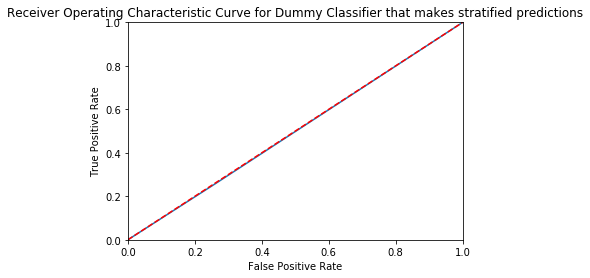


---------- Results Summary for Dummy Classifier that maximizes the prior for the column: Relationship ----------

0.0016582012176513672 seconds for  Dummy Classifier that maximizes the prior  to train
Using Relationship as a predictor for  Dummy Classifier that maximizes the prior  we get train accuracy of:  0.7425805571967459
Using Relationship as a predictor for  Dummy Classifier that maximizes the prior  we get test accuracy of:  0.7580439920014543

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4170          0
True >50k       1331          0

F1-score is: 0.0


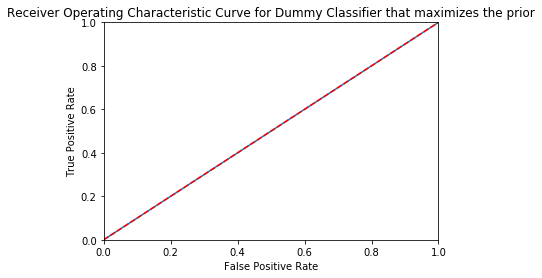


--------------- Returning Algorithm Results Summary for the feature: Race ---------------

---------- Results Summary for GaussianNB for the column: Race ----------

0.004599809646606445 seconds for  GaussianNB  to train
Using Race as a predictor for  GaussianNB  we get train accuracy of:  0.34322592373767213
Using Race as a predictor for  GaussianNB  we get test accuracy of:  0.33030358116706054

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k        566       3604
True >50k         80       1251

F1-score is: 0.4044616876818623


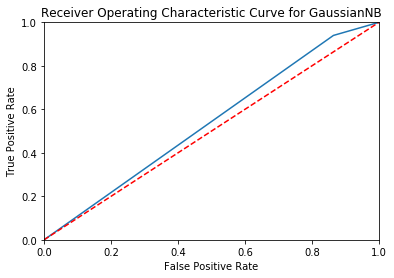


---------- Results Summary for SVM with Linear Kernel for the column: Race ----------

3.0378408432006836 seconds for  SVM with Linear Kernel  to train
Using Race as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.7425805571967459
Using Race as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7581818181818182

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4170          0
True >50k       1331          0

F1-score is: 0.0


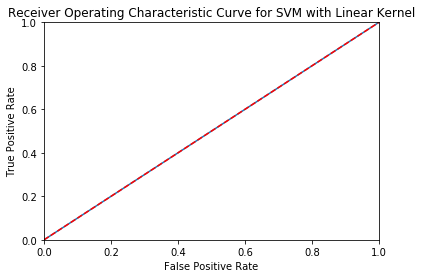


---------- Results Summary for SVM with Sigmoid Kernel for the column: Race ----------

5.220906019210815 seconds for  SVM with Sigmoid Kernel  to train
Using Race as a predictor for  SVM with Sigmoid Kernel  we get train accuracy of:  0.7425805571967459
Using Race as a predictor for  SVM with Sigmoid Kernel  we get test accuracy of:  0.7581818181818182

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4170          0
True >50k       1331          0

F1-score is: 0.0


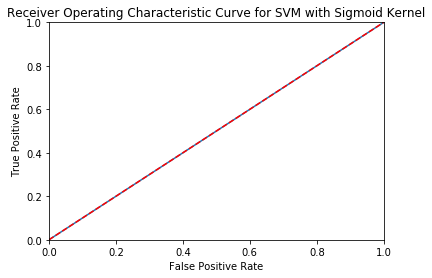


---------- Results Summary for SVM with Radial Basis Function Kernel for the column: Race ----------

4.730248212814331 seconds for  SVM with Radial Basis Function Kernel  to train
Using Race as a predictor for  SVM with Radial Basis Function Kernel  we get train accuracy of:  0.7425805571967459
Using Race as a predictor for  SVM with Radial Basis Function Kernel  we get test accuracy of:  0.7581818181818182

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4170          0
True >50k       1331          0

F1-score is: 0.0


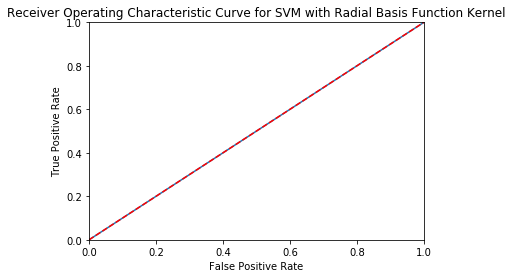


---------- Results Summary for Neural Network with ReLU activation for the column: Race ----------

0.3134129047393799 seconds for  Neural Network with ReLU activation  to train
Using Race as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.7425805571967459
Using Race as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7580439920014543

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4170          0
True >50k       1331          0

F1-score is: 0.0


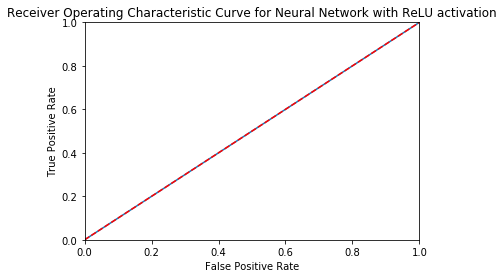


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Race ----------

0.18231415748596191 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Race as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.7425805571967459
Using Race as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7580439920014543

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4170          0
True >50k       1331          0

F1-score is: 0.0


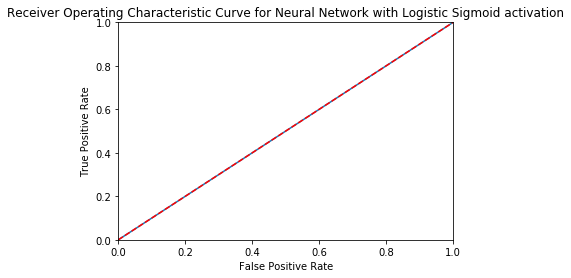


---------- Results Summary for Neural Network with tanh activation for the column: Race ----------

0.21335506439208984 seconds for  Neural Network with tanh activation  to train
Using Race as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.7425805571967459
Using Race as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7580439920014543

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4170          0
True >50k       1331          0

F1-score is: 0.0


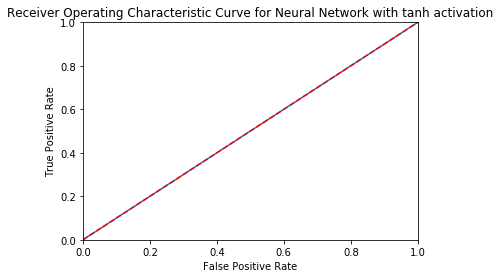


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: Race ----------

0.00400090217590332 seconds for  Dummy Classifier that predicts most frequent  to train
Using Race as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.7425805571967459
Using Race as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0.7580439920014543

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4170          0
True >50k       1331          0

F1-score is: 0.0


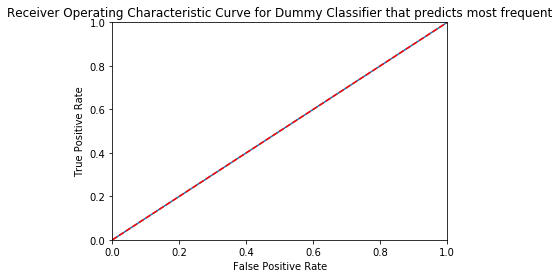


---------- Results Summary for Dummy Classifier that makes stratified predictions for the column: Race ----------

0.0017957687377929688 seconds for  Dummy Classifier that makes stratified predictions  to train
Using Race as a predictor for  Dummy Classifier that makes stratified predictions  we get train accuracy of:  0.6155069763214107
Using Race as a predictor for  Dummy Classifier that makes stratified predictions  we get test accuracy of:  0.6229776404290129

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3145       1025
True >50k        973        358

F1-score is: 0.26124505217704214


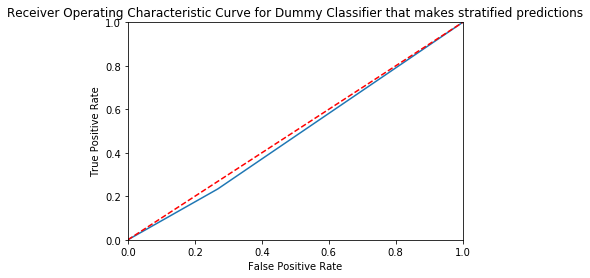


---------- Results Summary for Dummy Classifier that maximizes the prior for the column: Race ----------

0.0016219615936279297 seconds for  Dummy Classifier that maximizes the prior  to train
Using Race as a predictor for  Dummy Classifier that maximizes the prior  we get train accuracy of:  0.7425805571967459
Using Race as a predictor for  Dummy Classifier that maximizes the prior  we get test accuracy of:  0.7580439920014543

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4170          0
True >50k       1331          0

F1-score is: 0.0


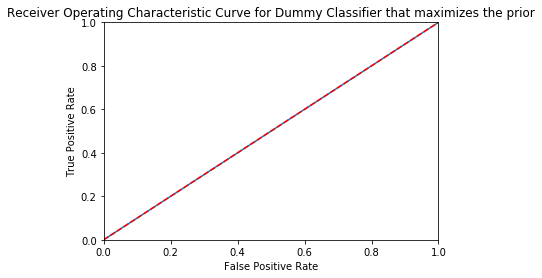


--------------- Returning Algorithm Results Summary for the feature: All Columns ---------------

---------- Results Summary for GaussianNB for the column: All Columns ----------

0.02218794822692871 seconds for  GaussianNB  to train
Using All Columns as a predictor for  GaussianNB  we get train accuracy of:  0.5852383765850111
Using All Columns as a predictor for  GaussianNB  we get test accuracy of:  0.5598982003272133

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       1818       2352
True >50k         69       1262

F1-score is: 0.5104145601617796


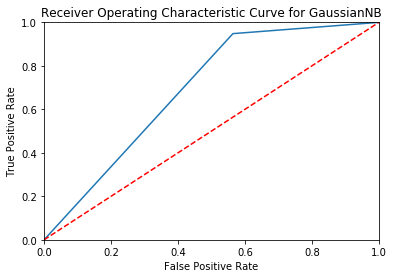


---------- Results Summary for SVM with Linear Kernel for the column: All Columns ----------

24.71137809753418 seconds for  SVM with Linear Kernel  to train
Using All Columns as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.8473844475753306
Using All Columns as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.8536363636363636

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3798        372
True >50k        513        818

F1-score is: 0.6489488298294328


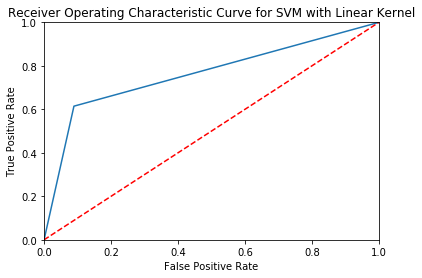


---------- Results Summary for SVM with Sigmoid Kernel for the column: All Columns ----------

19.410375833511353 seconds for  SVM with Sigmoid Kernel  to train
Using All Columns as a predictor for  SVM with Sigmoid Kernel  we get train accuracy of:  0.7838931054856156
Using All Columns as a predictor for  SVM with Sigmoid Kernel  we get test accuracy of:  0.8272727272727273

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3558        612
True >50k        584        747

F1-score is: 0.5553903345724908


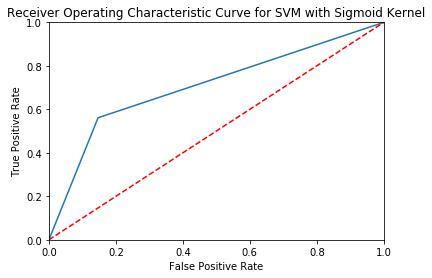


---------- Results Summary for SVM with Radial Basis Function Kernel for the column: All Columns ----------

19.499923944473267 seconds for  SVM with Radial Basis Function Kernel  to train
Using All Columns as a predictor for  SVM with Radial Basis Function Kernel  we get train accuracy of:  0.8535654228968776
Using All Columns as a predictor for  SVM with Radial Basis Function Kernel  we get test accuracy of:  0.8463636363636363

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3834        336
True >50k        530        801

F1-score is: 0.6491085899513777


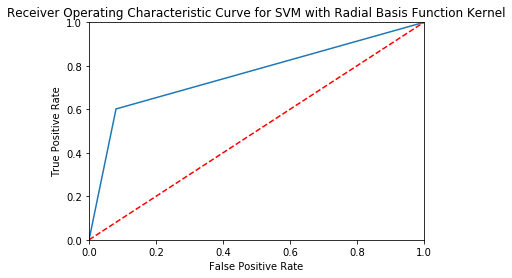


---------- Results Summary for Neural Network with ReLU activation for the column: All Columns ----------

1.5718750953674316 seconds for  Neural Network with ReLU activation  to train
Using All Columns as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.8563832204699359
Using All Columns as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.8520269041992365

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3810        360
True >50k        454        877

F1-score is: 0.6830218068535825


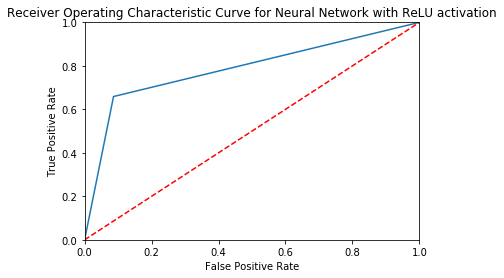


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: All Columns ----------

1.1201210021972656 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using All Columns as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.8569286006453666
Using All Columns as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.8476640610798036

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3817        353
True >50k        485        846

F1-score is: 0.6687747035573124


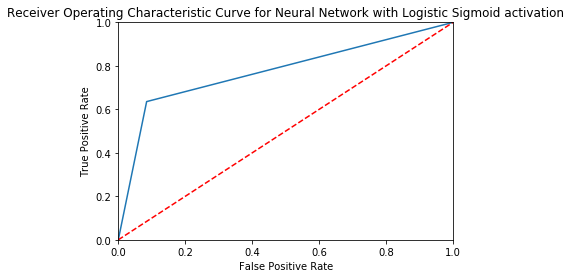


---------- Results Summary for Neural Network with tanh activation for the column: All Columns ----------

1.4165029525756836 seconds for  Neural Network with tanh activation  to train
Using All Columns as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.8569286006453666
Using All Columns as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.8489365569896382

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3839        331
True >50k        500        831

F1-score is: 0.6666666666666666


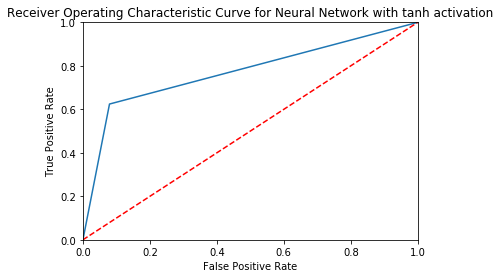


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: All Columns ----------

0.003930091857910156 seconds for  Dummy Classifier that predicts most frequent  to train
Using All Columns as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.7425805571967459
Using All Columns as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0.7580439920014543

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4170          0
True >50k       1331          0

F1-score is: 0.0


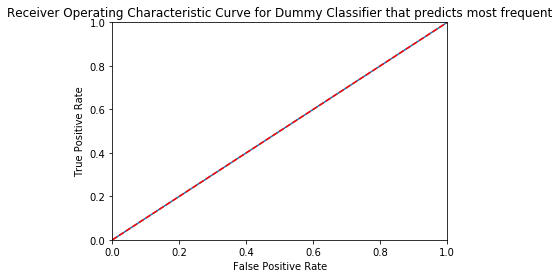


---------- Results Summary for Dummy Classifier that makes stratified predictions for the column: All Columns ----------

0.0033648014068603516 seconds for  Dummy Classifier that makes stratified predictions  to train
Using All Columns as a predictor for  Dummy Classifier that makes stratified predictions  we get train accuracy of:  0.6208698813798118
Using All Columns as a predictor for  Dummy Classifier that makes stratified predictions  we get test accuracy of:  0.6238865660788947

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3122       1048
True >50k        983        348

F1-score is: 0.25578034682080925


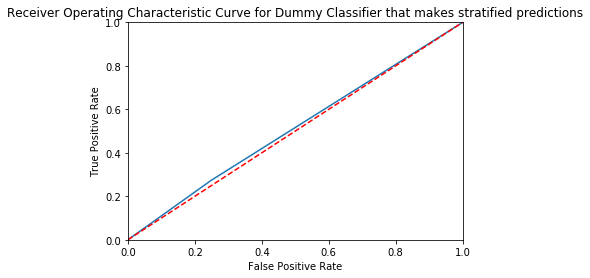


---------- Results Summary for Dummy Classifier that maximizes the prior for the column: All Columns ----------

0.005213737487792969 seconds for  Dummy Classifier that maximizes the prior  to train
Using All Columns as a predictor for  Dummy Classifier that maximizes the prior  we get train accuracy of:  0.7425805571967459
Using All Columns as a predictor for  Dummy Classifier that maximizes the prior  we get test accuracy of:  0.7580439920014543

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4170          0
True >50k       1331          0

F1-score is: 0.0


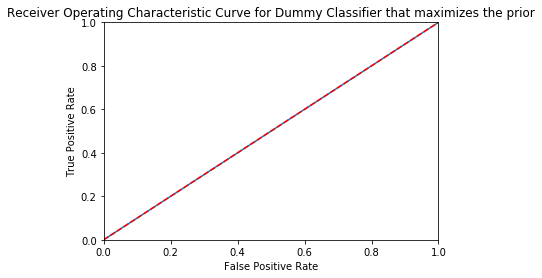

In [20]:
Y = np.array(new_df.iloc[:,46:47]) #labels
num_training = int(0.8*Y.shape[0])  #80% of the data for training
sc = StandardScaler()

for i in range(len(ranges)):
    print('--------------- Returning Algorithm Results Summary for the feature:',columns[i],'---------------')
    print()
    for j in range(len(classifiers)):
        if j == 1 or j == 2 or j == 3:   # if it is svm do cross validation
            return_results(classifiers[j],names[j],True,False,i)
        elif j == 7 or j == 8 or j ==9:  # if it is a dummyclassifier, calculate accuracy the proper way
            return_results(classifiers[j],names[j],False,True,i)  
        else:    # if a regular classifier, just do the normal operations
            return_results(classifiers[j],names[j],False,False,i)